In [7]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import scipy.io

from leitmotifs.plotting import *
from leitmotifs.lama import *

from leitmotifs.competitors import *

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")



def plot_motiflet(series, motiflet, dims, motif_length, title=None):    
    fig, ax = plt.subplots(figsize=(4,2))

    offset = 0.0
    for dim in dims:
        dim_data_raw = pd.DataFrame(data=np.array([series[dim, i:i+motif_length] for i in motiflet]))        
        offset -= 2 * (dim_data_raw.values.max() - dim_data_raw.values.min())
        ax = sns.lineplot(data=dim_data_raw.melt().set_index("variable") + offset)
        
    if title:
        ax.set_title(title)
        
    sns.despine()
    fig.patch.set_visible(False)
    ax.legend().set_visible(False)
    ax.axis('off')
    return fig, ax
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


physio
	 ['physio', 0, 0]
Boxing
	 ['Boxing', 0.5714285714285714, 0.3]
	 [ 258  674  876 1086 1516 1796 2046 2458 2736 3170 3366 3680 3978 4792]
	 [7]
	 5


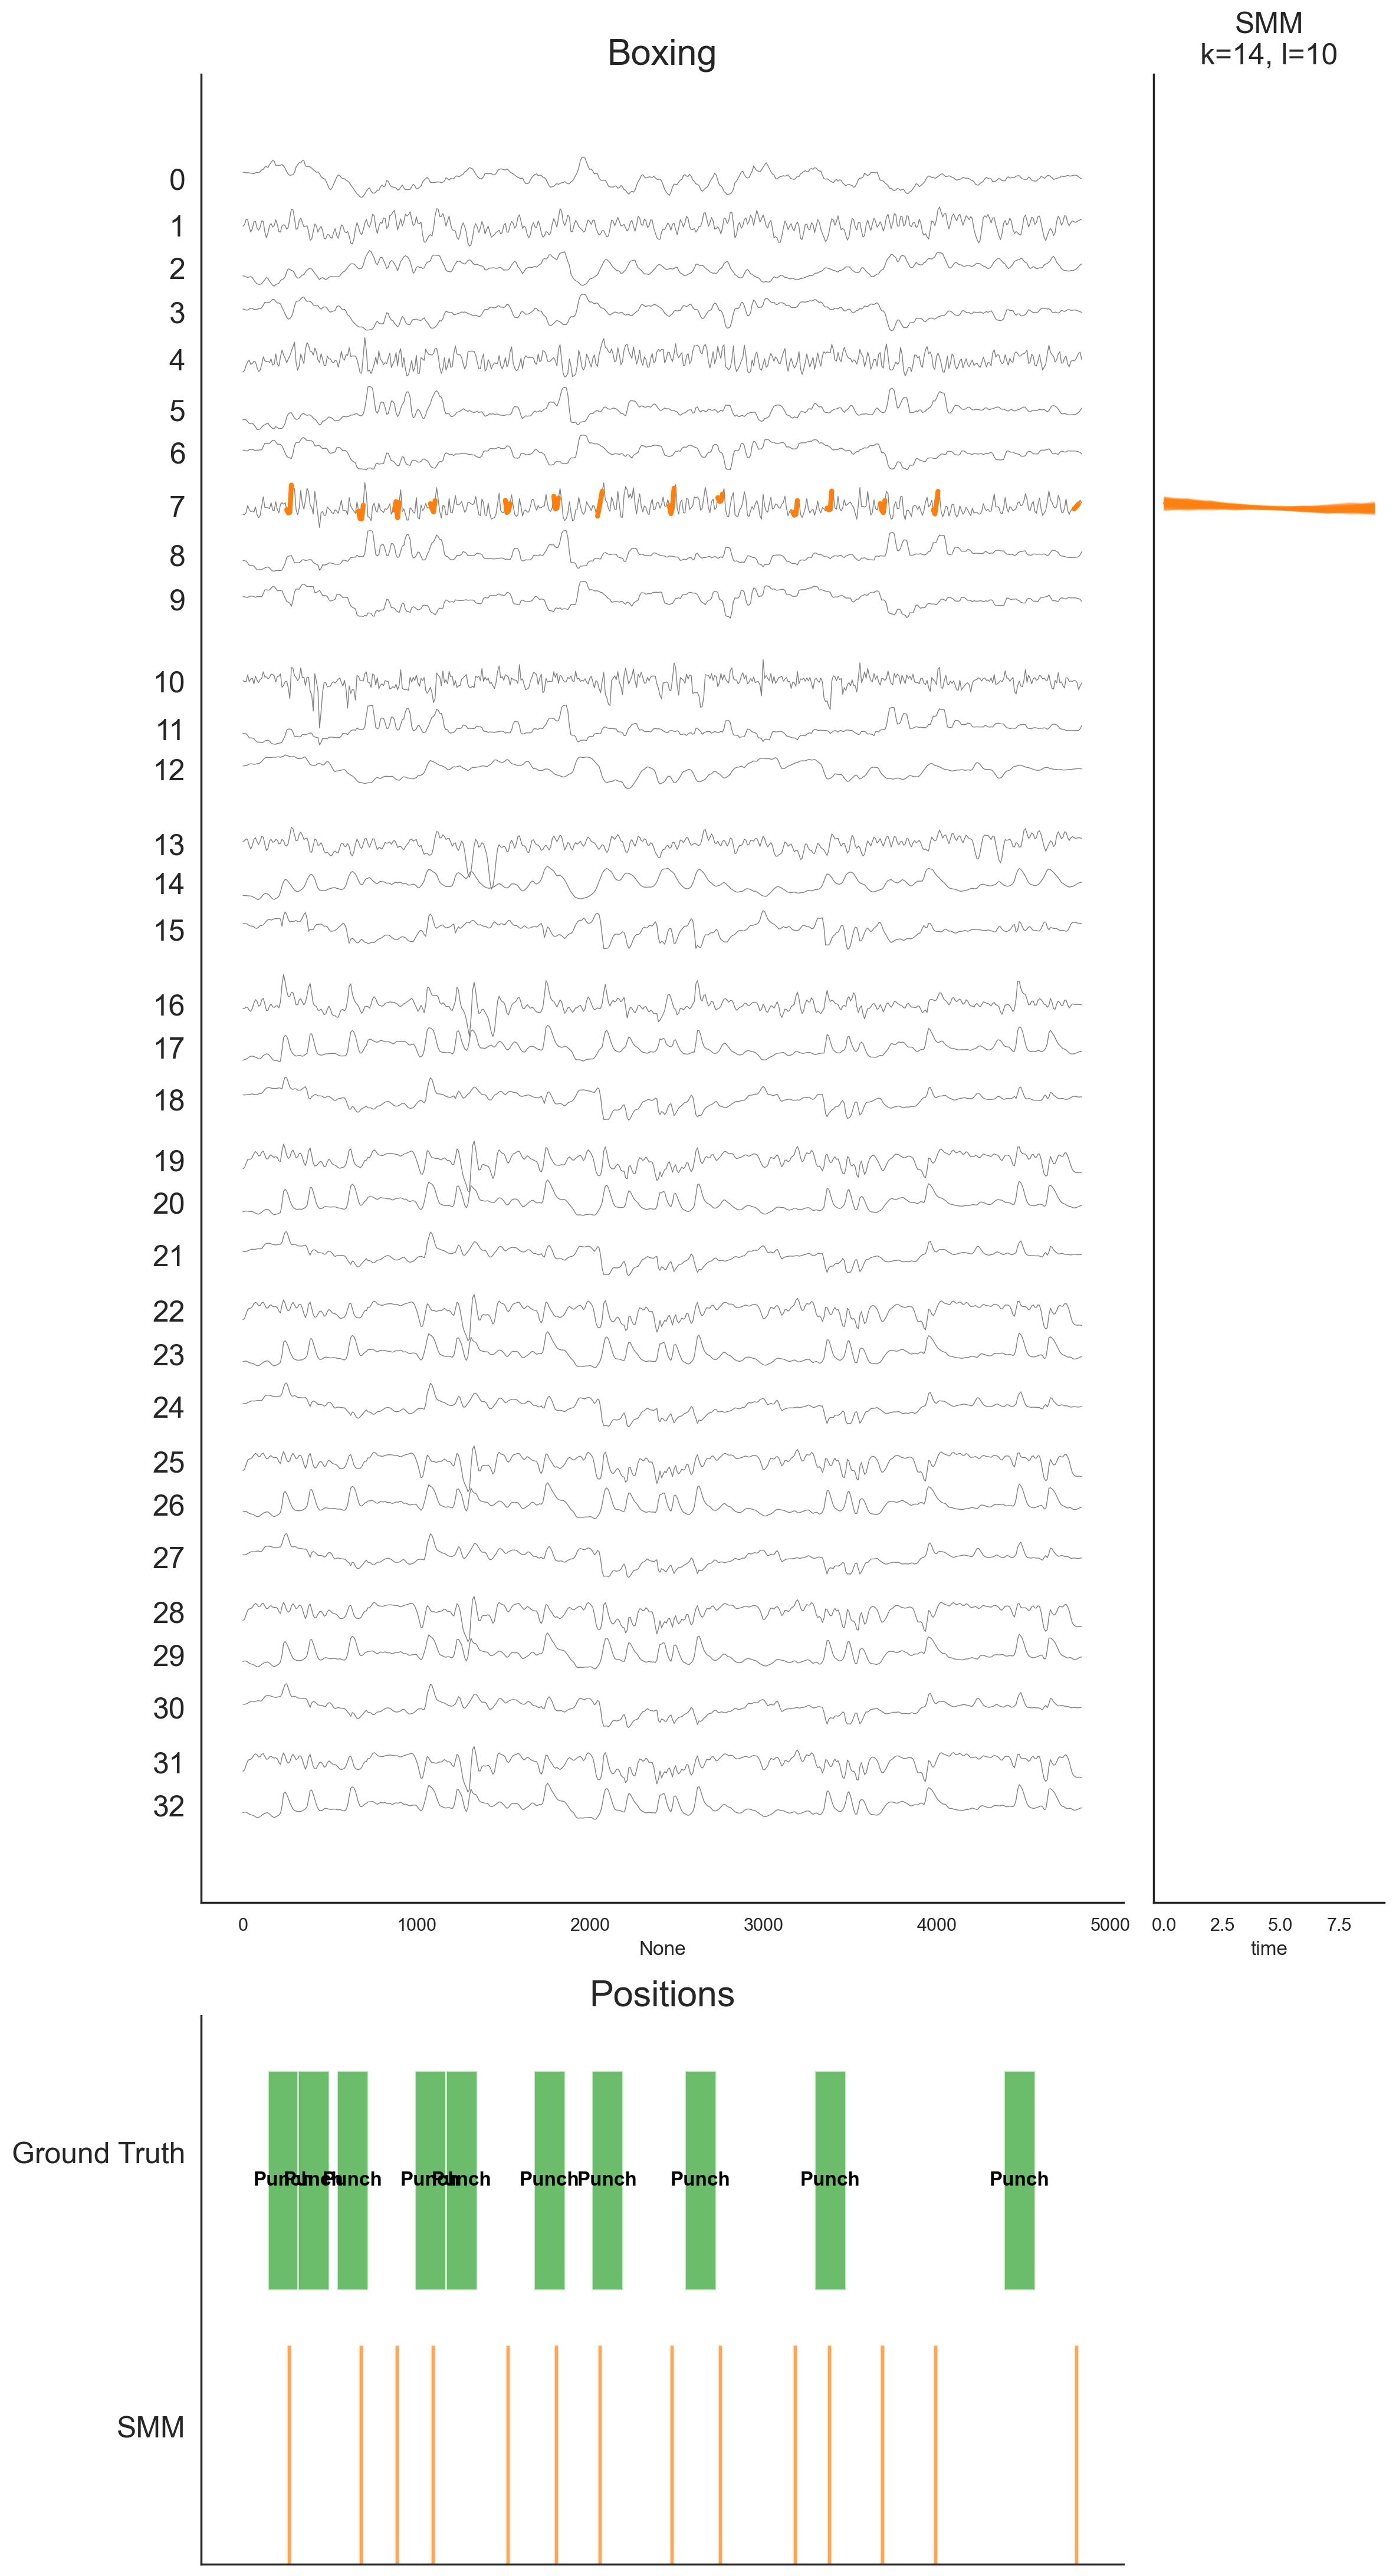

Swordplay
	 ['Swordplay', 0.0, 0.0]
Basketball
	 ['Basketball', 0.5, 0.2]
	 [250 494]
	 [10]
	 5


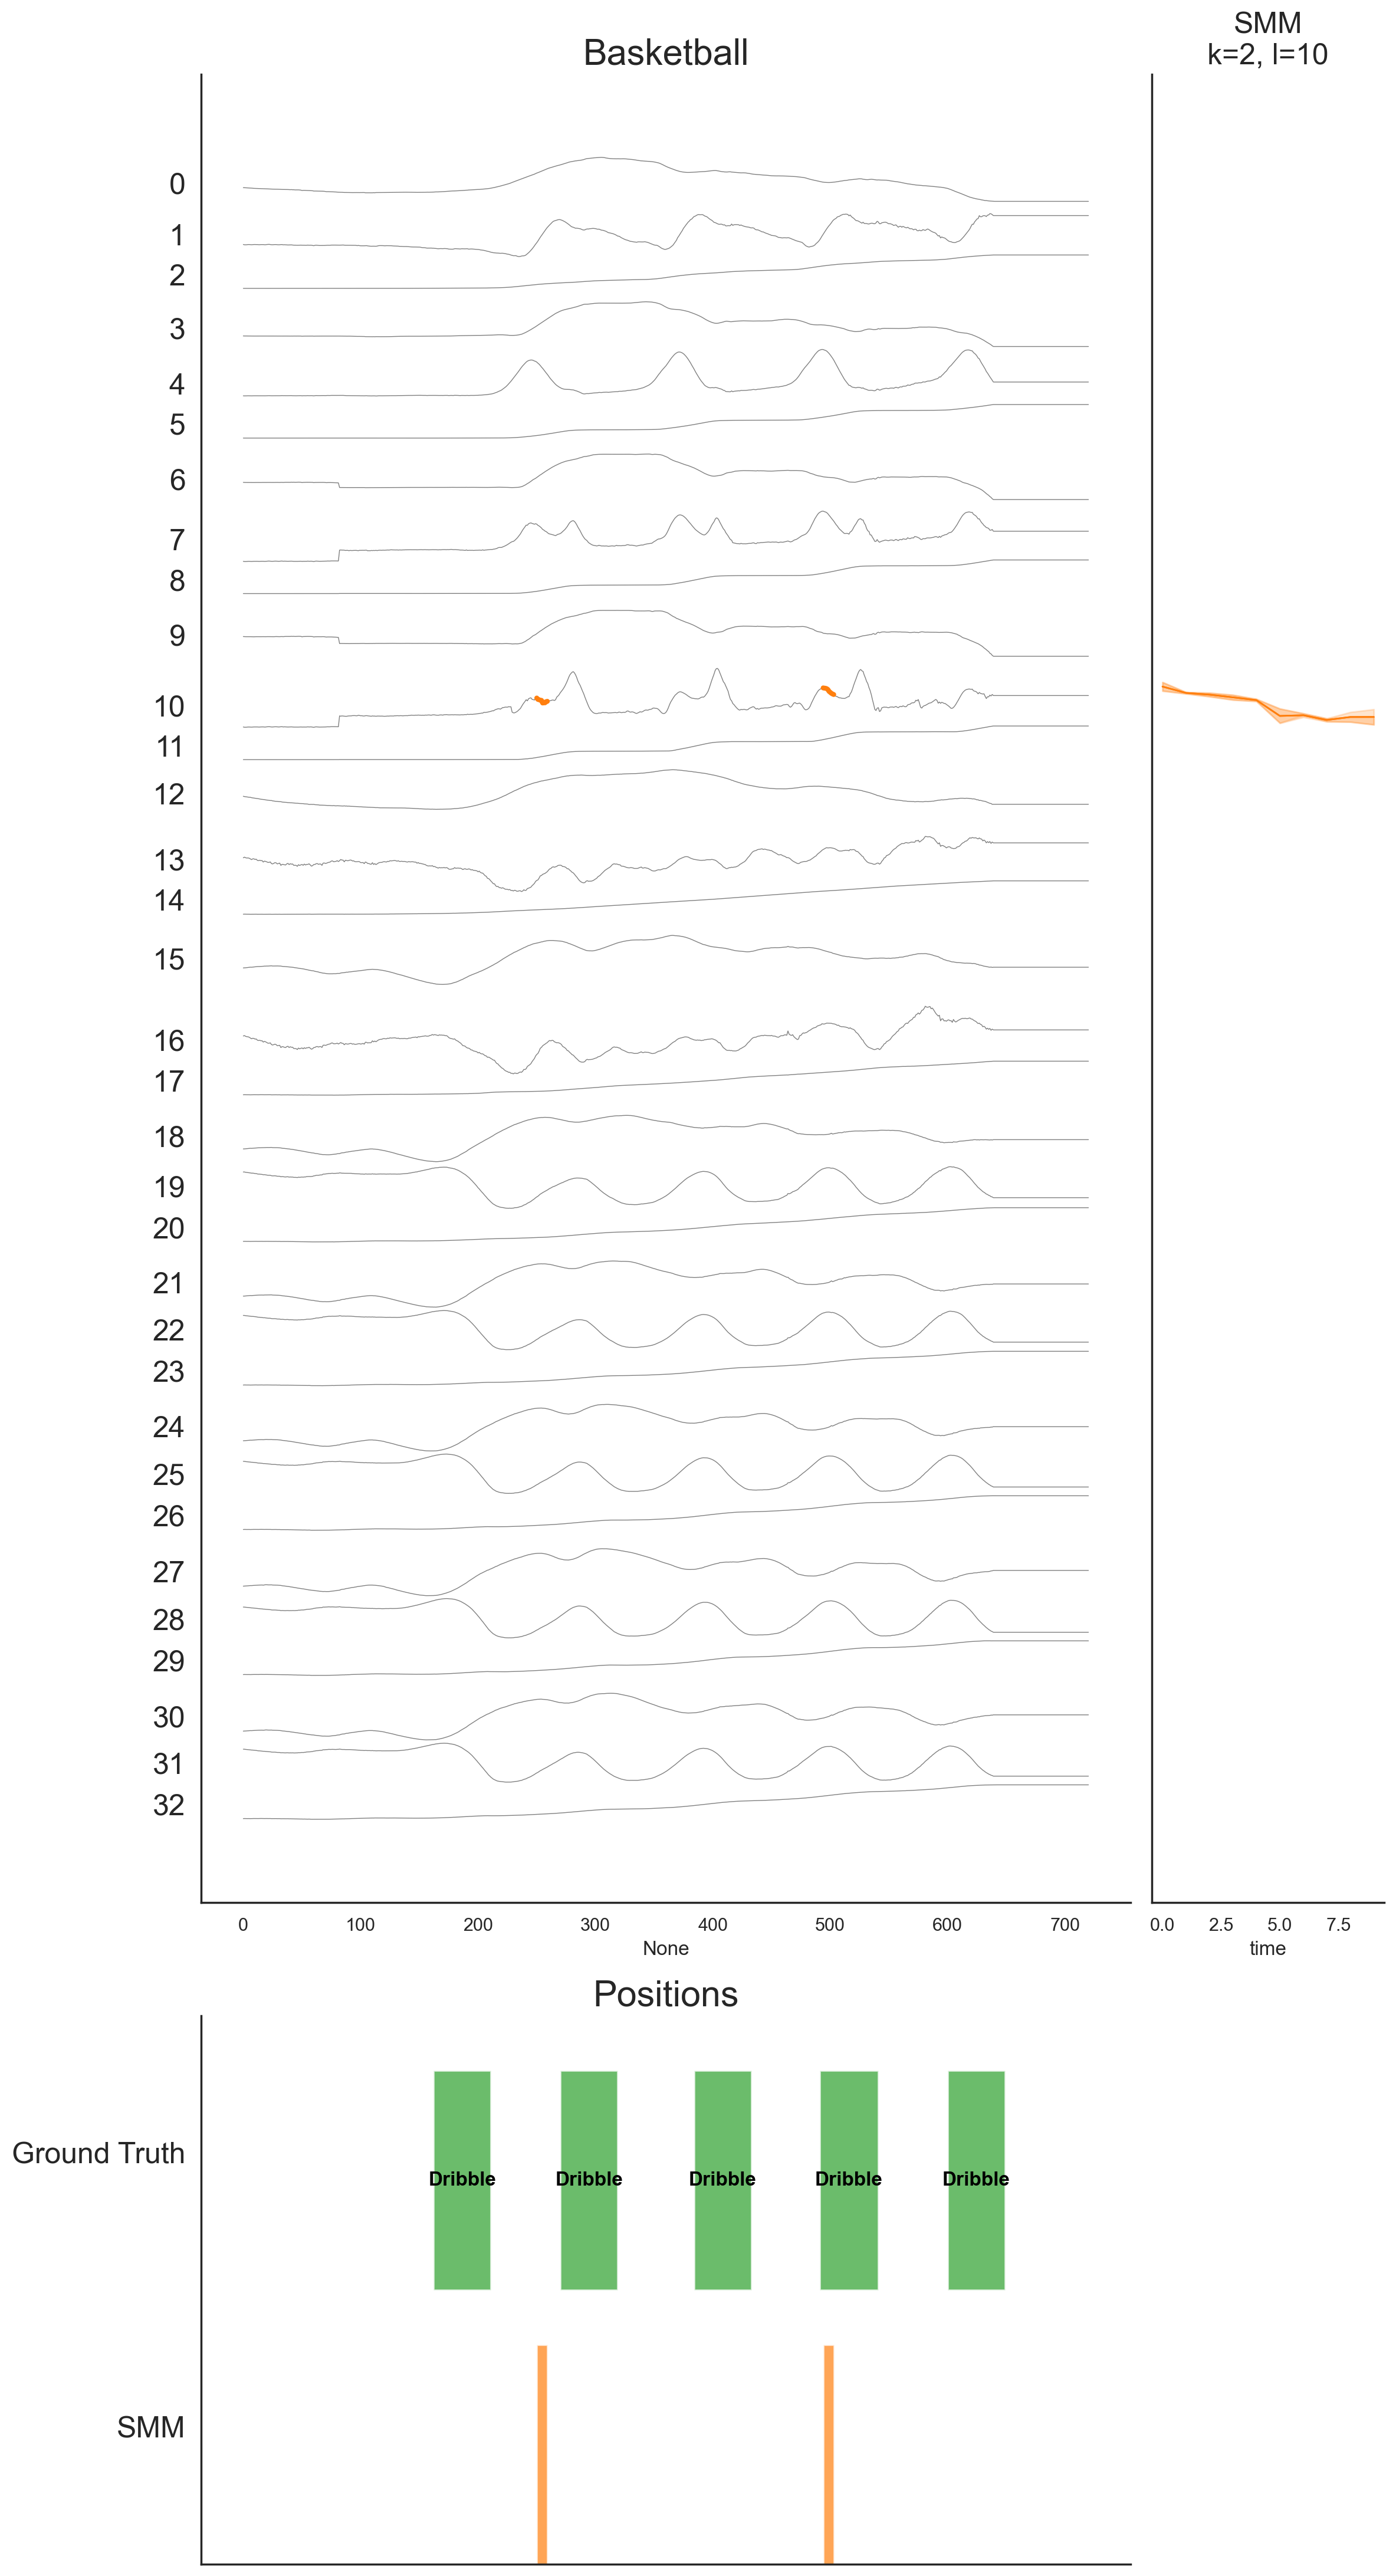

Charleston - Side By Side Female
	 ['Charleston - Side By Side Female', 0.5, 0.3333333333333333]
	 [ 12 176 294 336]
	 [3]
	 22


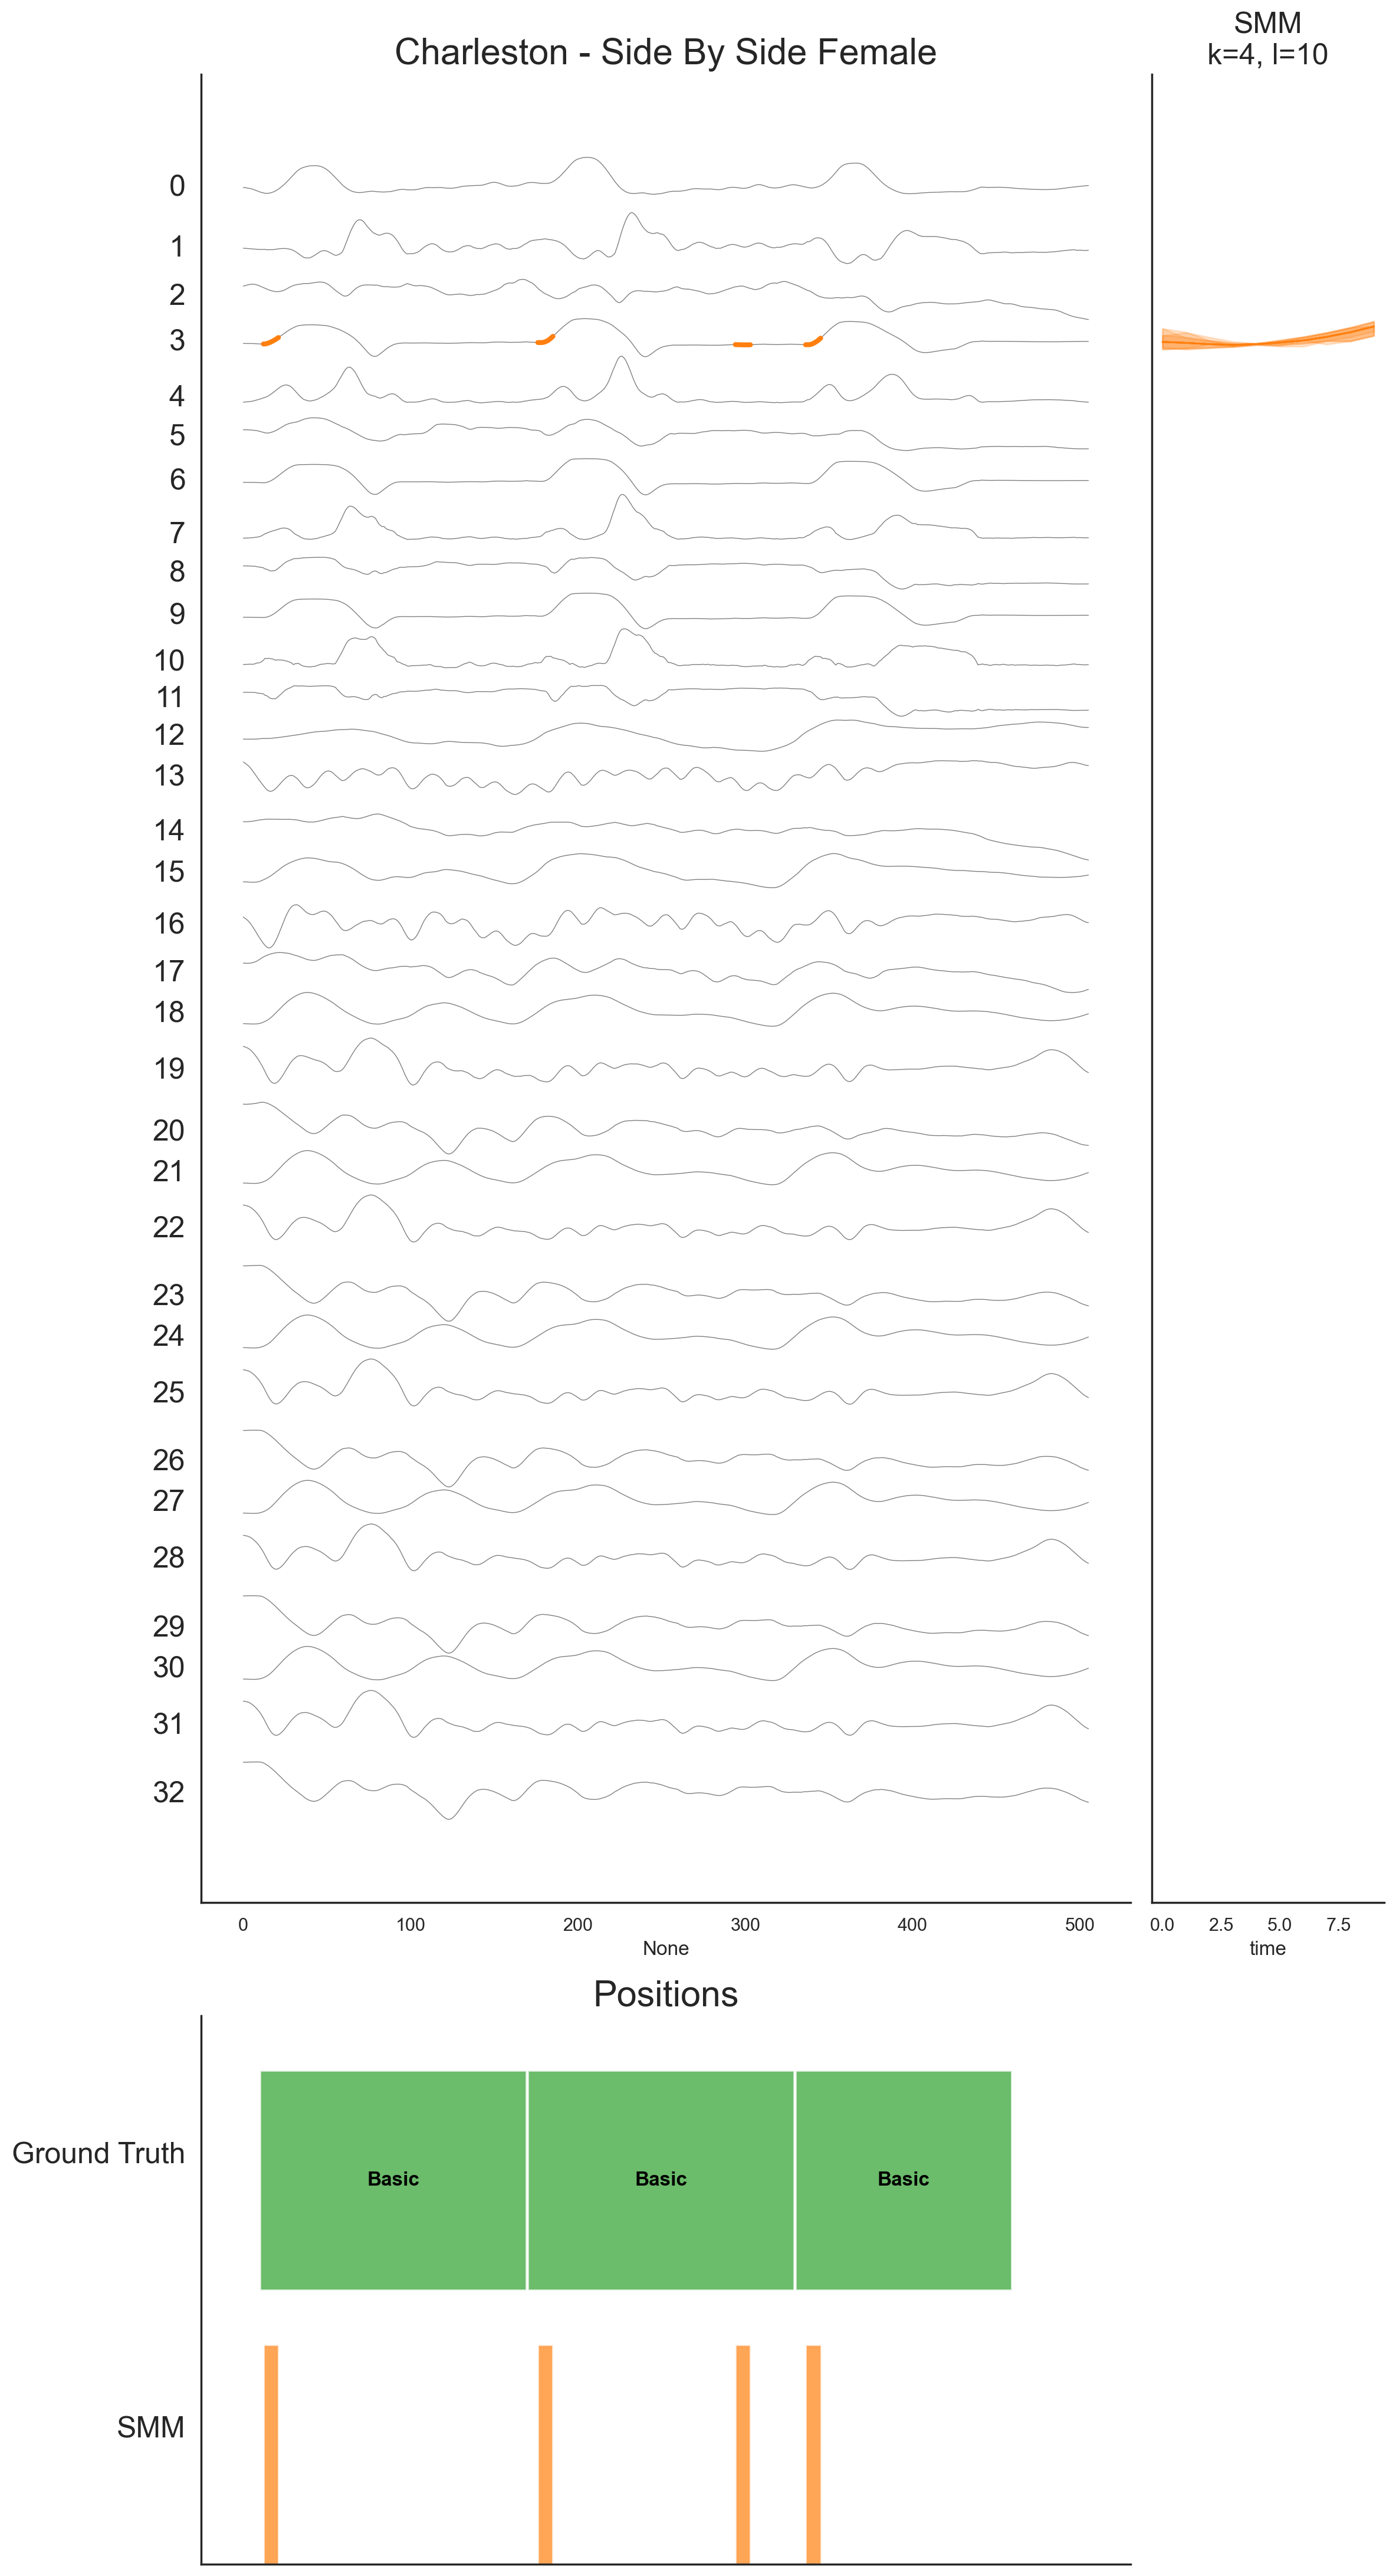

The file smm_results/lama_benchmark/Motif_6_DepO_2_DepT_2.mat does not exist.
birds
	 ['birds', 0.16666666666666666, 0.25]
	 [  82  146  223  252  323  348  540  704  836  944 1996 2152]
	 [1]
	 5


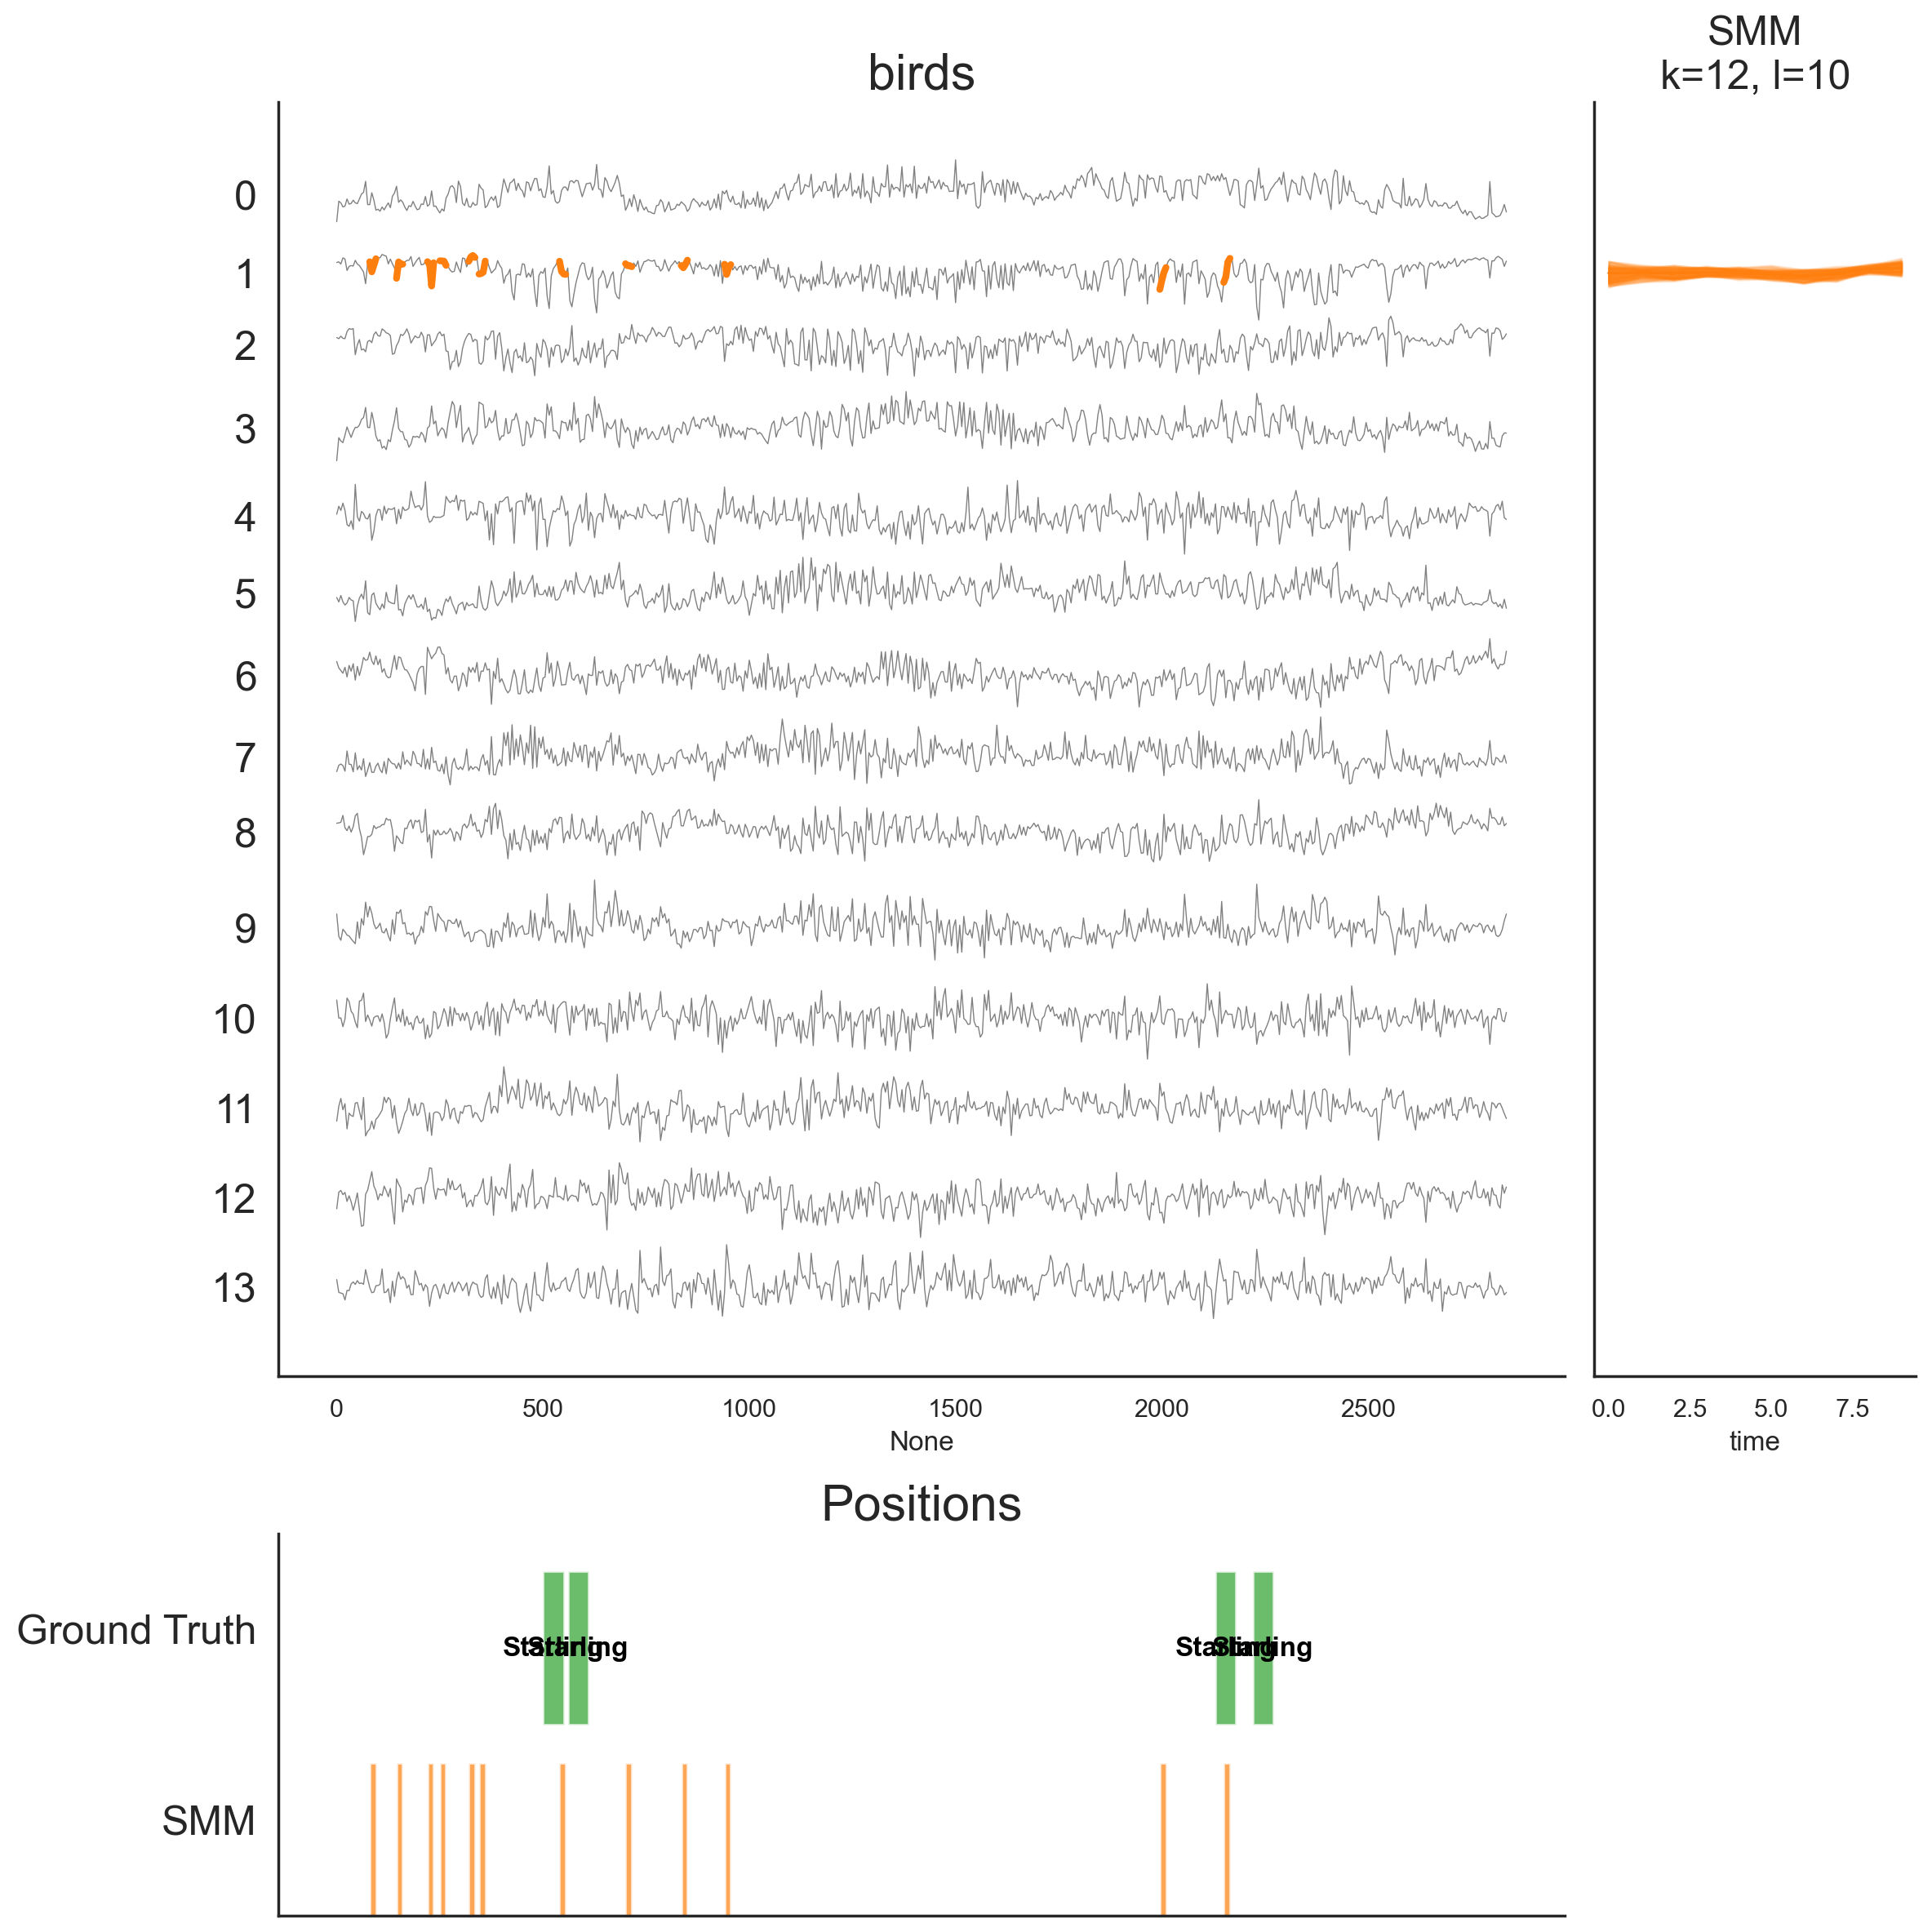

What I've Done - Linkin Park
	 ["What I've Done - Linkin Park", 0.36764705882352944, 1.0]
	 [ 374  522  871 1014 1302 1476 1646 1782 2584 2728 2940 2976 3070 3196
 3416 4224 4302 4450 4670 4792 4918 5136 5296 5456 5500 7024 7242 7462
 7716 8102 8782]
	 [2]
	 5


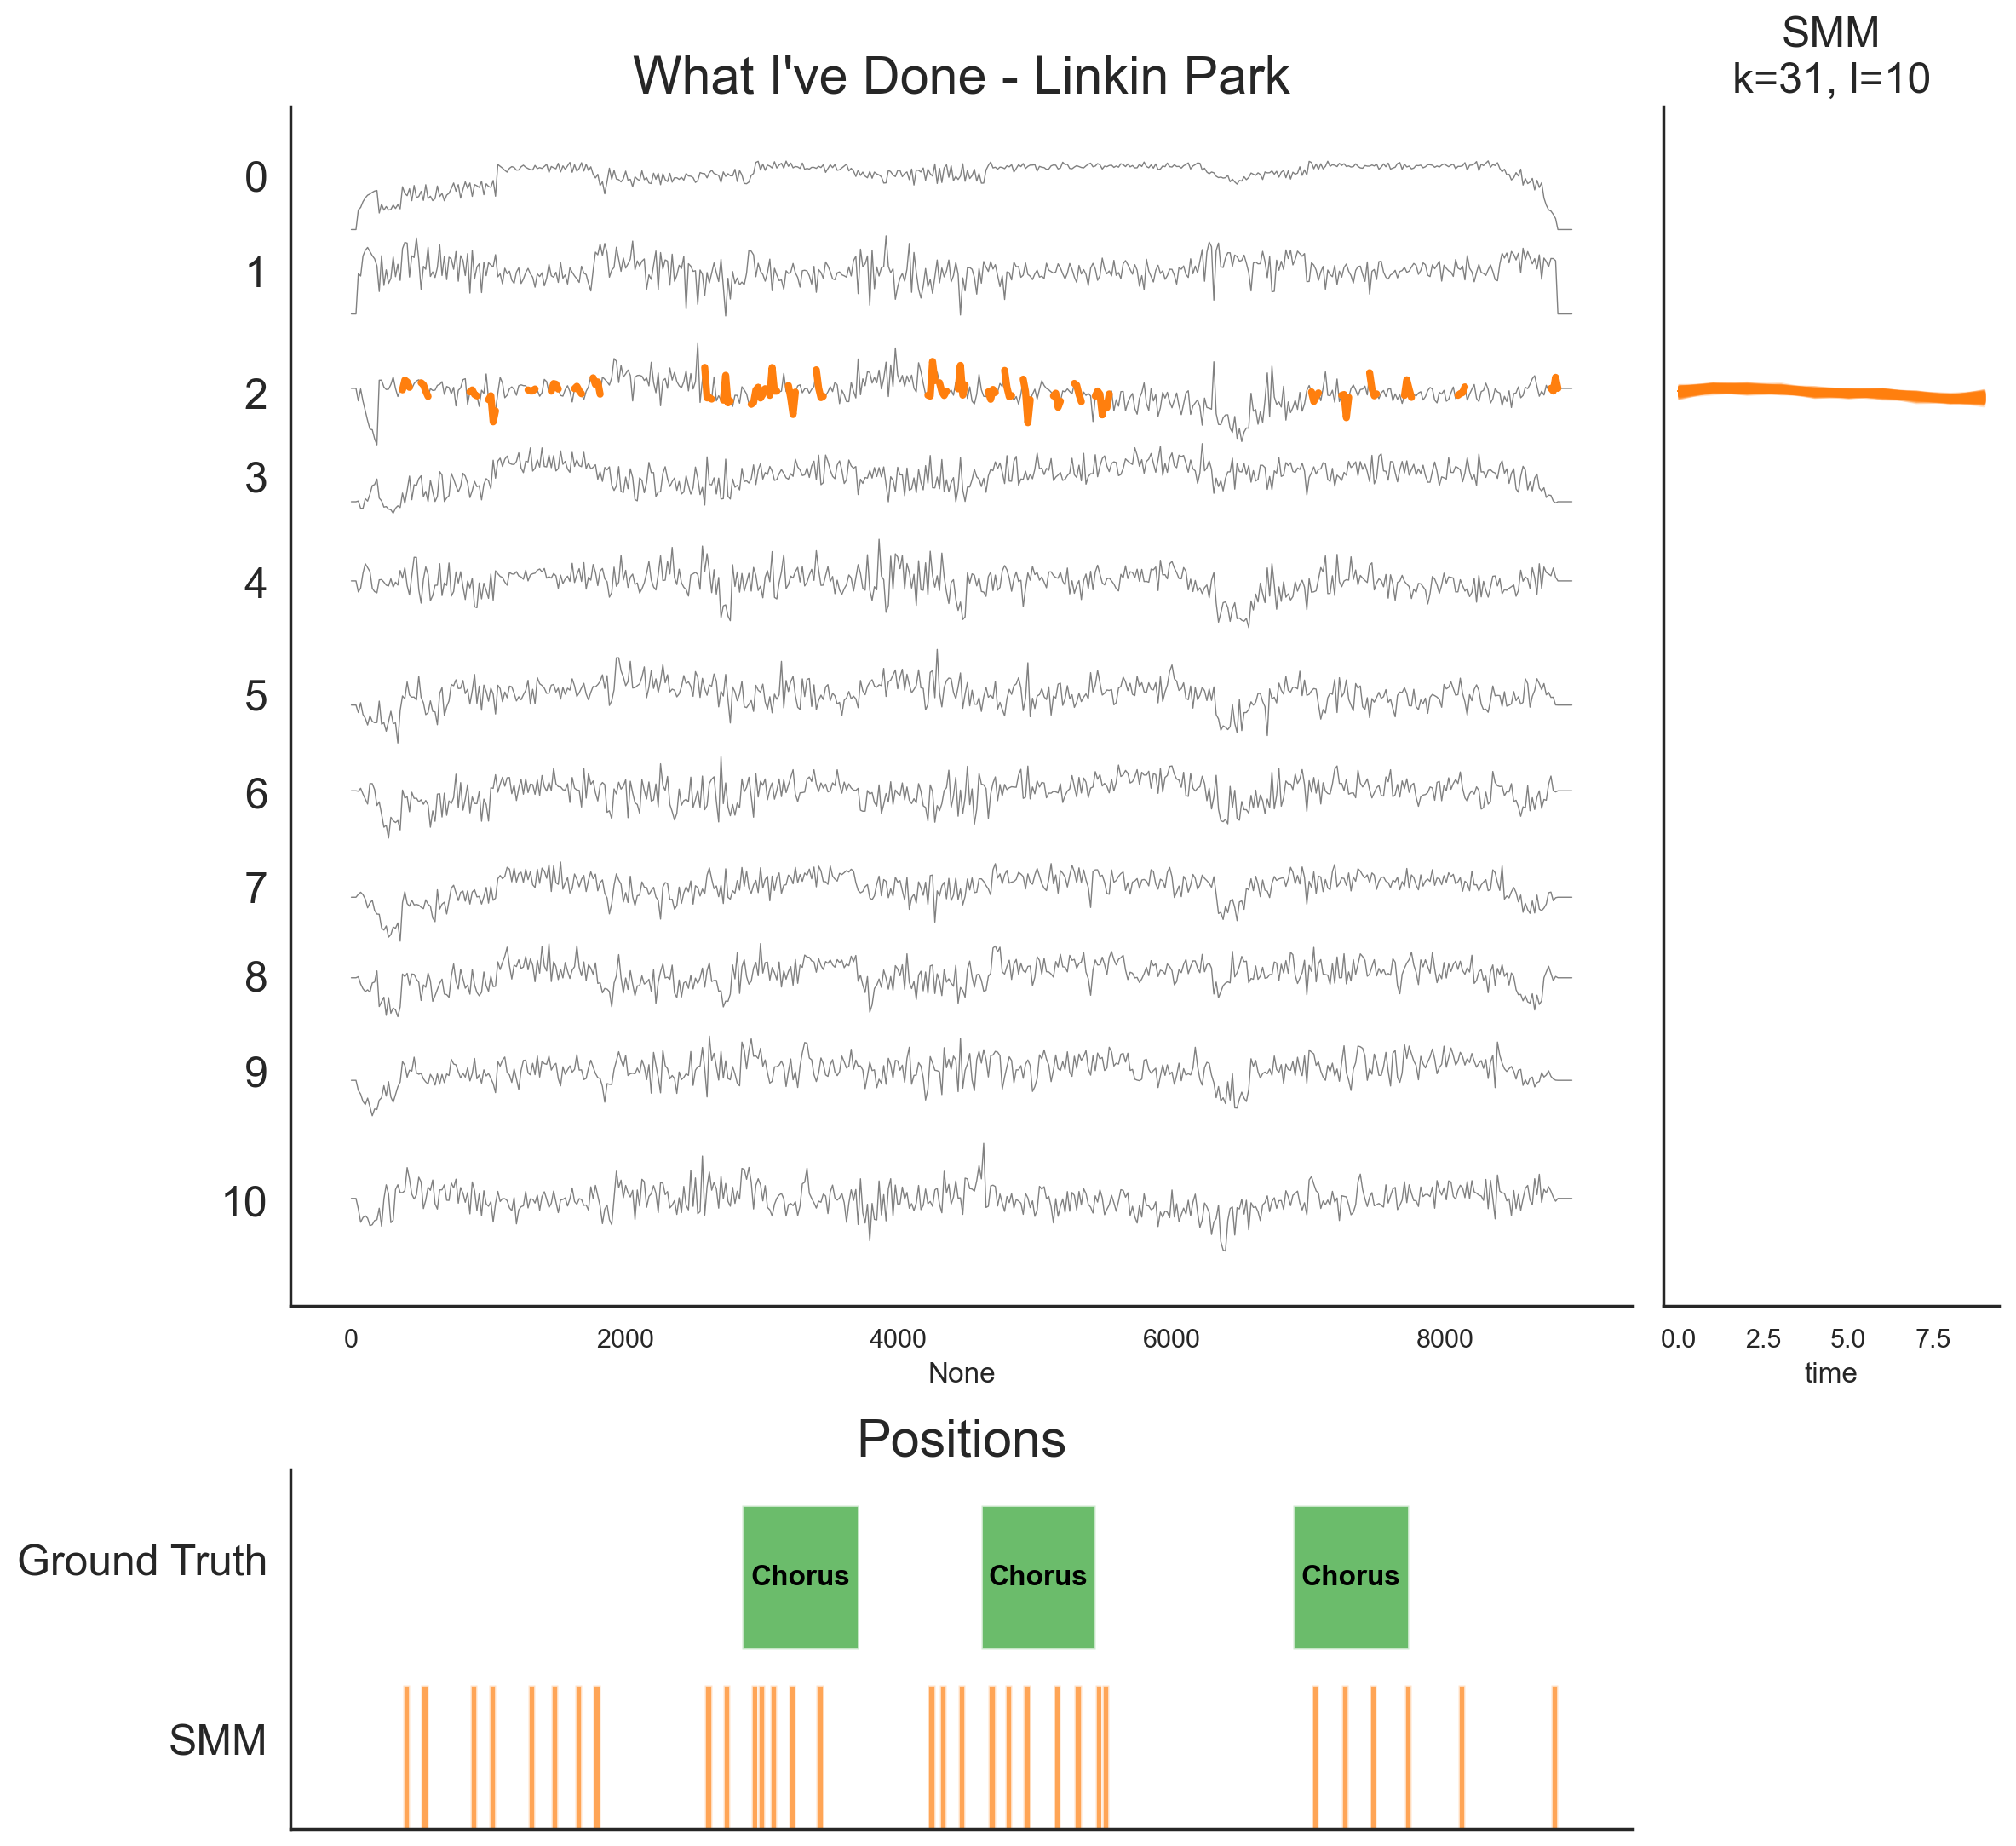

Numb - Linkin Park
	 ['Numb - Linkin Park', 0.1956521739130435, 0.8]
	 [ 626  814  858 1896 2082 2300 2315 2590 2688 2876 3152 3246 3350 3964
 4104 4150 4254 4330 4430 4554 4569 4849 4944 5131 5279 5494 5602 5652
 5756 5881 5976 6060 6152 6165 6445 6543 6726 7032 7158 7406]
	 [0]
	 5


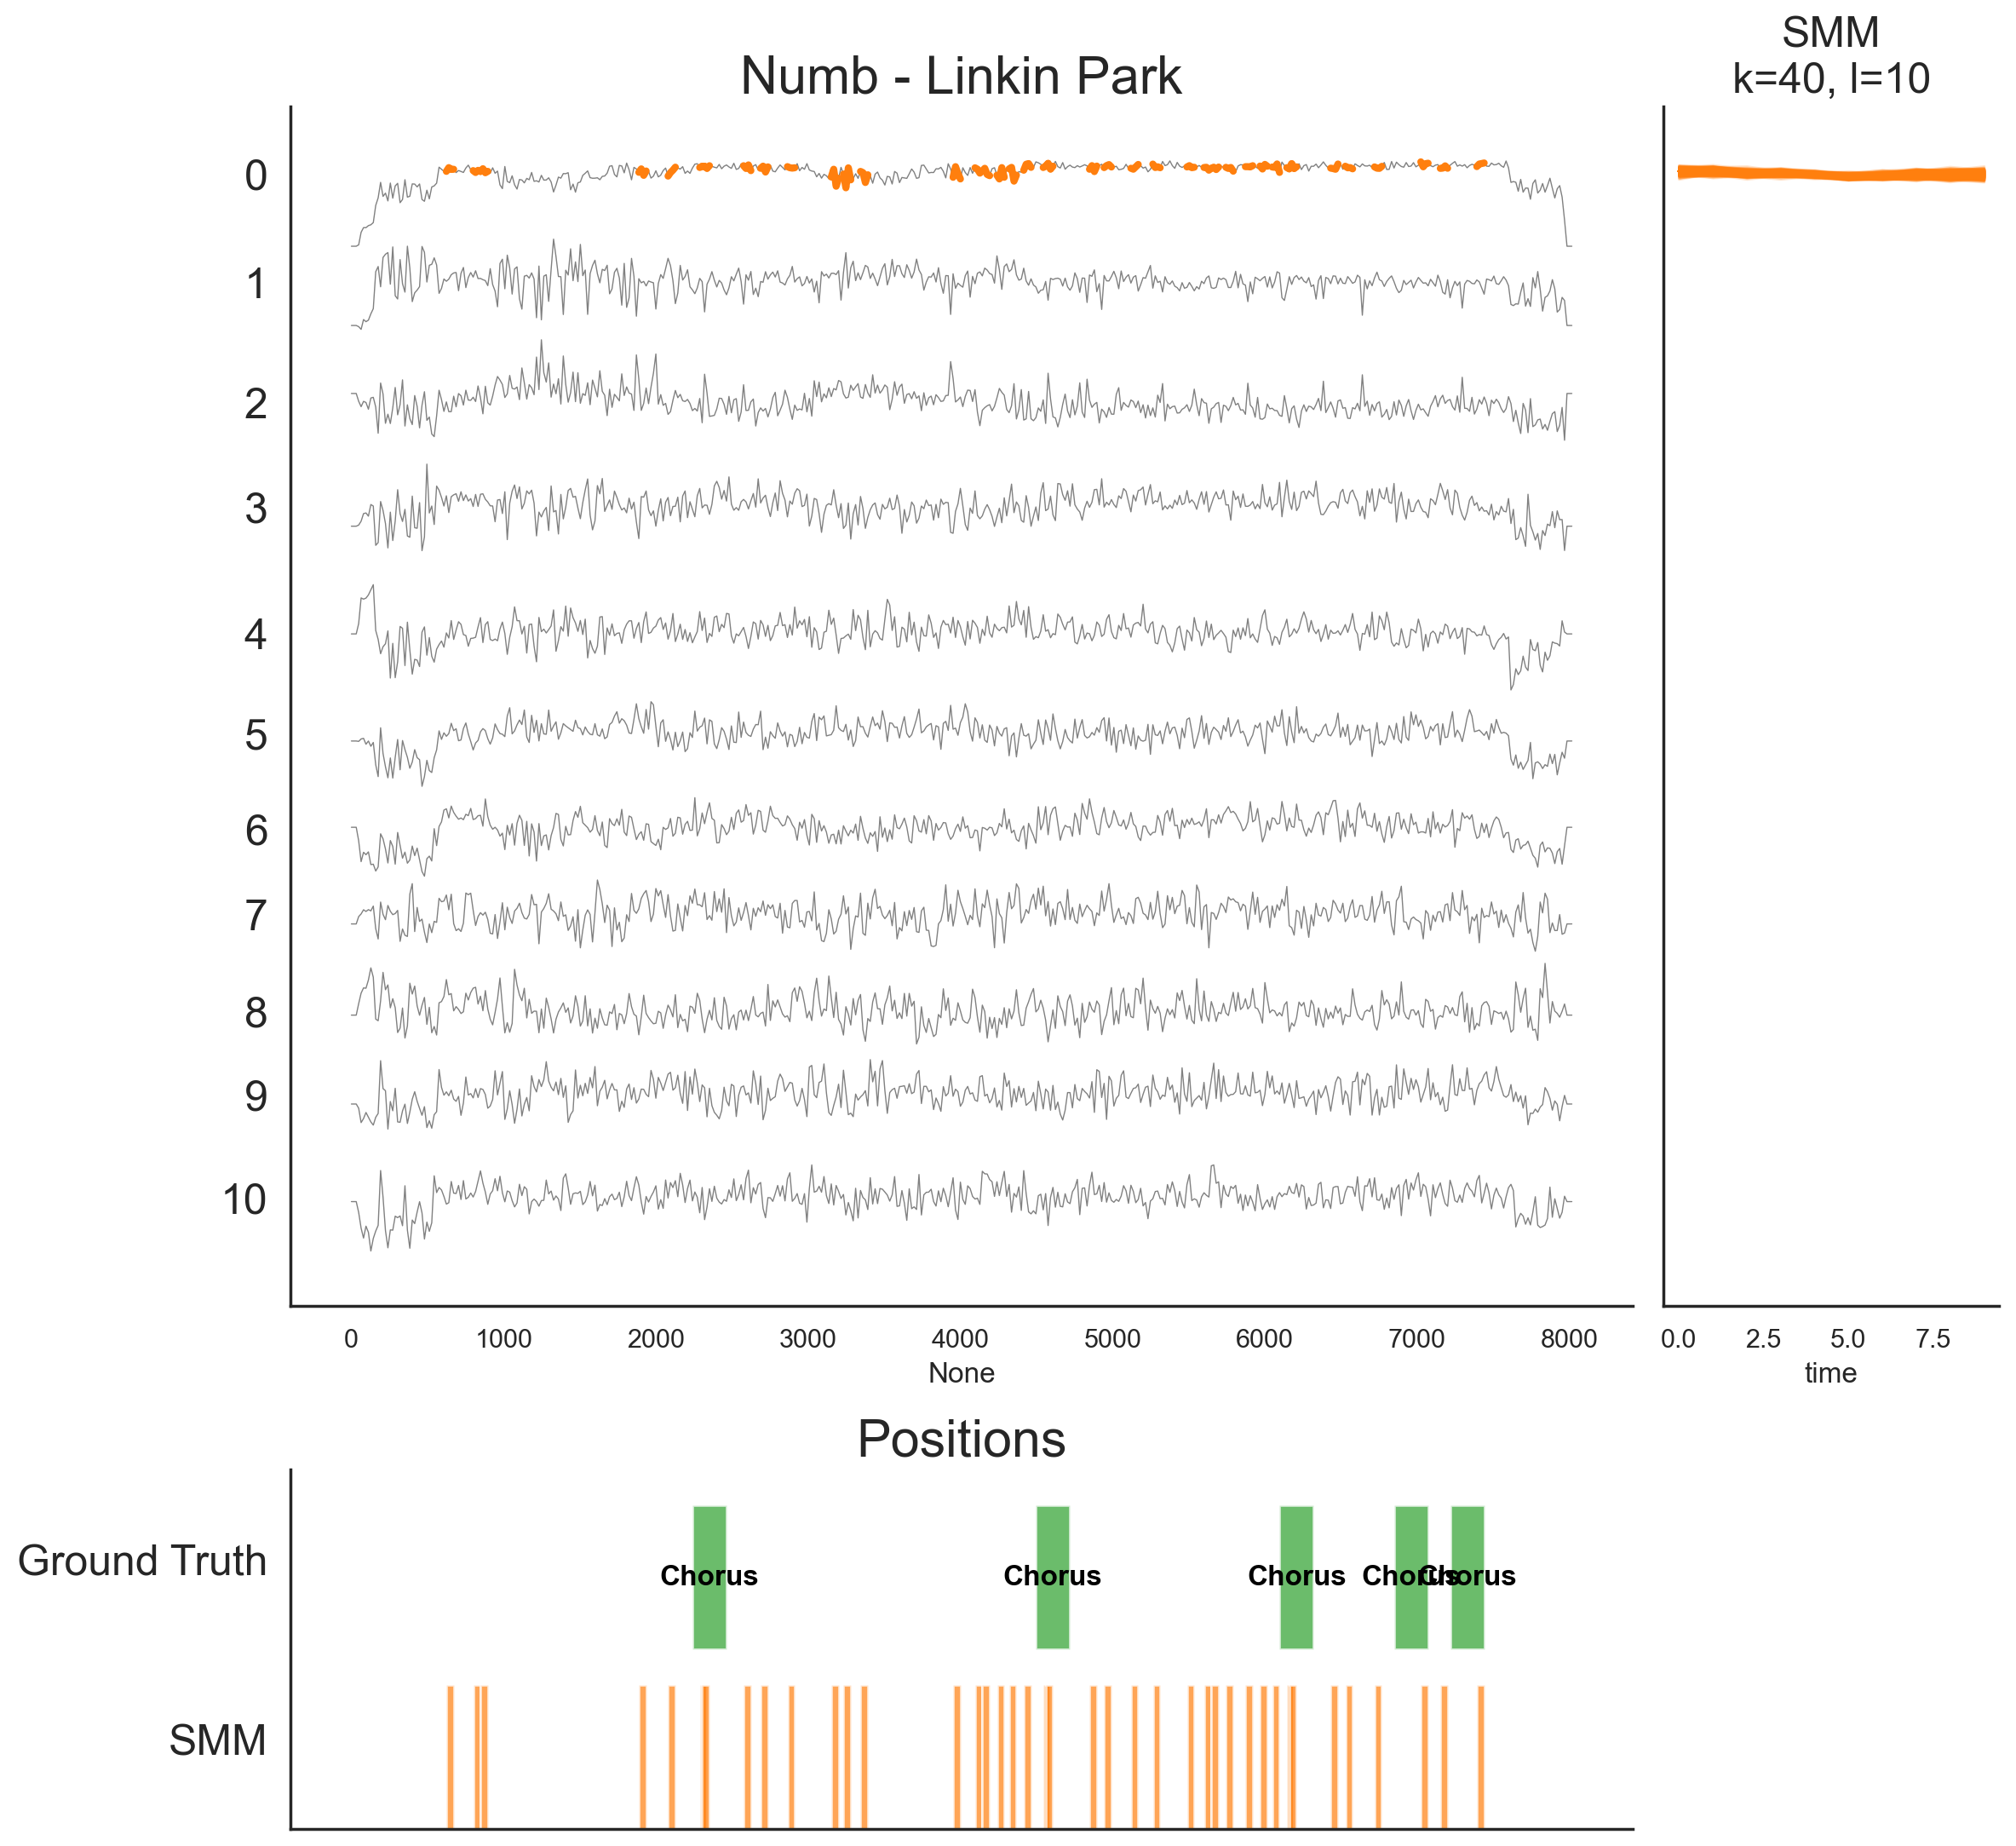

Vanilla Ice - Ice Ice Baby
	 ['Vanilla Ice - Ice Ice Baby', 0.5925925925925926, 1.0]
	 [ 786 1244 1630 1836 2662 2842 3022 5756 6236 6416 6594 8380 8558 8738
 9272 9452 9630]
	 [1]
	 5


In [ ]:
dataset_names = [
    'physio', 
    'Boxing', 
    'Swordplay', 
    'Basketball', 
    'Charleston - Side By Side Female', 
    'crypto', 
    'birds', 
    "What I've Done - Linkin Park",
    'Numb - Linkin Park', 
    'Vanilla Ice - Ice Ice Baby', 
    'Queen David Bowie - Under Pressure', 
    'The Rolling Stones - Paint It, Black', 
    'Star Wars - The Imperial March', 
    'Lord of the Rings Symphony - The Shire']


scores = {}
# Load the .mat file
for i in range(1, 15):

    series_path = "../datasets/benchmark/"+str(i)+".csv"
    series = pd.read_csv(series_path, header=None).T
    df_gt = read_ground_truth(series_path)

    file = "smm_results/lama_benchmark/Motif_"+str(i)+"_DepO_2_DepT_2.mat"
    # file = "../tests/smm_benchmark/results/2/Motif_"+str(i)+"_DepO_2_DepT_2.mat"
    
    # break
    # some dataset found no motifs
    if not os.path.exists(file):
        print(f"The file {file} does not exist.")
        continue

    print(dataset_names[i-1])
    
    mat_file = scipy.io.loadmat(file, struct_as_record=False, squeeze_me=True)
    motif_bag = mat_file["MotifBag"]
    
    if not isinstance(motif_bag, np.ndarray):
        motif_bag = [motif_bag]

    best_f_score = 0.0
    best_motif_set = []
    best_dims = []
    best_length = 0
    precision, recall = 0, 0
    
    for motif_bag in motif_bag:
        if motif_bag:
            startIdx = motif_bag.startIdx
            
            motif_set = startIdx
            dims = motif_bag.depd[0] - 1   #   matlab uses 1-indexing but python 0-indexing
            if not isinstance(dims, np.ndarray):
                dims = [dims]
            
            length = motif_bag.Tscope[0]            
            if length == 0:
                length = 1

            # plot_motiflet(series.values, motif_set, dims=dims, motif_length=length)
            # plt.show()

            precision, recall = compute_precision_recall(
                    np.sort(motif_set), df_gt.values[0, 0], length)                
            
            f_score = 2*(precision*recall) / (precision + recall + 1e-8)
            if f_score > best_f_score:
                best_f_score = f_score
                best_motif_set = motif_set
                best_length =  length
                best_dims = dims
                best_precision = precision
                best_recall = recall

    
    scores[i] = [dataset_names[i - 1], precision, recall]
    print("\t", scores[i])
    
    if len(best_motif_set)>0:
        if best_length == 1:
            best_length = 5
        print("\t", best_motif_set)
        print("\t", best_dims)
        print("\t", best_length)

        fig, axes = plot_motifsets(
            dataset_names[i - 1],
            series,
            motifsets=np.array([best_motif_set]),
            motifset_names=["SMM"],
            leitmotif_dims=np.array([best_dims]),
            motif_length=best_length,
            ground_truth=df_gt,
            show=False)

        plt.savefig("images/smm_"+str(i)+".pdf")
        plt.show()
        # break

scores